In [36]:
import pandas as pd
import ydata_profiling as ydp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc

from aux_functions.aux_plots import (plot_boxplot_histogram, plot_scatterplot, plot_distribution_actual_predicted)
from aux_functions.statistics import (test_pearson_correlation, apply_linear_regression, evaluate_linear_regression)

# Importing the dataset

In [37]:
columns = ['lenght_of_stay', 'age', 'infection_risk', 'routine_culturing_ratio', 'routine_xray_ratio', 'num_beds', 'med_school_affil', 'region', 'avg_census', 'num_nurses', 'avelbl_services']
df = pd.read_csv("data/dataset.txt", sep=" ", header=None, names=columns)
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services
1,7.1,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
2,8.8,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
3,8.3,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
4,8.9,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
5,11.2,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0


# EDA

## Univariate analysis

### Measures of central tendency and dispersion

In [38]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df.describe()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services
count,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0
mean,9.6,53.2,4.4,15.8,81.6,252.2,1.8,2.4,191.4,173.2,43.2
std,1.9,4.5,1.3,10.2,19.4,192.8,0.4,1.0,153.8,139.3,15.2
min,6.7,38.8,1.3,1.6,39.6,29.0,1.0,1.0,20.0,14.0,5.7
25%,8.3,50.9,3.7,8.4,69.5,106.0,2.0,2.0,68.0,66.0,31.4
50%,9.4,53.2,4.4,14.1,82.3,186.0,2.0,2.0,143.0,132.0,42.9
75%,10.5,56.2,5.2,20.3,94.1,312.0,2.0,3.0,252.0,218.0,54.3
max,19.6,65.9,7.8,60.5,133.5,835.0,2.0,4.0,791.0,656.0,80.0


### Boxplots and histograms
* See "./imgs/box_hist" for results

In [39]:
cols = df.columns
for col in cols:
    if col != 'region' and col != 'med_school_affil':
        fig = plot_boxplot_histogram(df[col], col)
        fig.savefig(f'./imgs/box_hist/{col}.png')  # Save the figure

### Testing for normality on infection_risk

In [40]:
norm_test = sc.shapiro(np.array(df['infection_risk']))
print("Statistic of Shapiro Wilk test: ", norm_test.statistic)
print("p-value of Shapiro Wilk test: ", norm_test.pvalue)

Statistic of Shapiro Wilk test:  0.9820429682731628
p-value of Shapiro Wilk test:  0.1338874250650406


- Interpretation of S-W test: Since we had a small sample size, determining the distribution of the variable X was important for choosing an appropriate statistical method. So a Shapiro-Wilk test was performed and did not show evidence of non-normality (W = 0.98, p-value = 0.13).

## Bivariate analysis

### Calculating the correlation matrix

<Axes: >

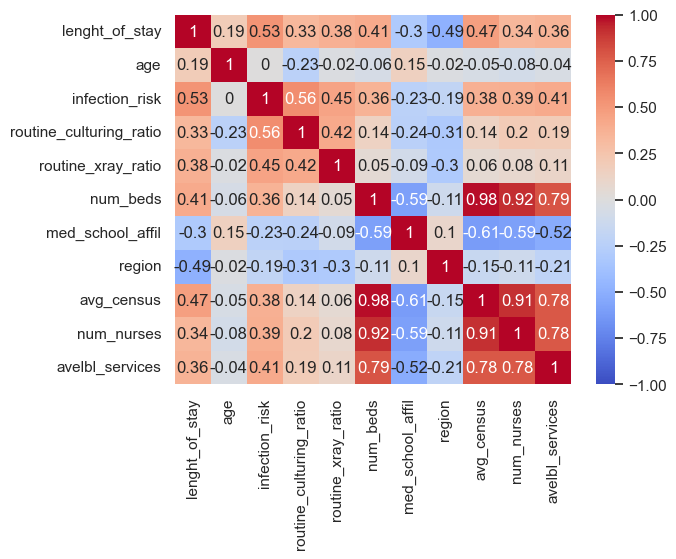

In [41]:
corr_matrix = round(df.corr(),2)
corr_matrix
sns.heatmap(corr_matrix, annot=True, vmin=-1,vmax=1, cmap=sns.color_palette("coolwarm", as_cmap=True))

### Applying a pearson's correlation test

In [42]:
target_variable = 'infection_risk'
for col in ['lenght_of_stay', 'routine_culturing_ratio']:
    pearson_res = test_pearson_correlation(df, col, target_variable)
    print(">> Pearson's correlation result for", col)
    print('Pearsons r:', round(pearson_res.statistic,2), ';', 'pValue:', round(pearson_res.pvalue,3))
    print(pearson_res.confidence_interval()) # Im not sure if this is a 0.95 confidence interval! Weirdly didn't find the info in the docs

>> Pearson's correlation result for lenght_of_stay
Pearsons r: 0.53 ; pValue: 0.0
ConfidenceInterval(low=0.3868337609236219, high=0.6537510724268812)
>> Pearson's correlation result for routine_culturing_ratio
Pearsons r: 0.56 ; pValue: 0.0
ConfidenceInterval(low=0.4175602271913731, high=0.6742438110841824)


* Analysis: There is a statisticaly significant moderate linear correlation between lenght of stay and infection risk; and the same occurs for routine_culturing_ratio and infection risk

### Evaluating linear relationship between variables of interest

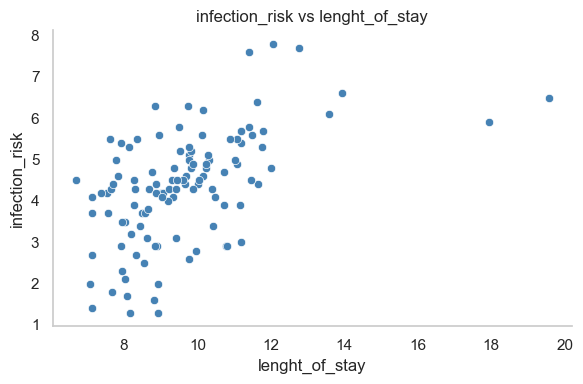

In [43]:
plot_scatterplot(df, 'lenght_of_stay', 'infection_risk')

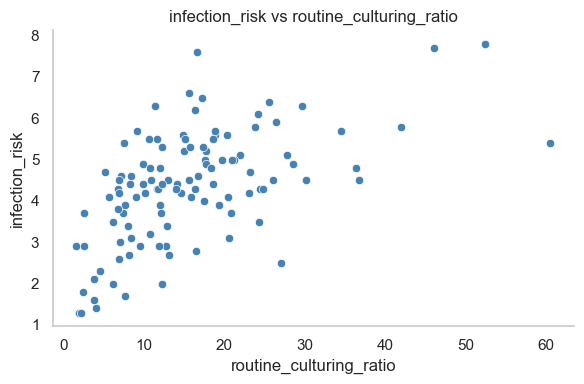

In [44]:
plot_scatterplot(df, 'routine_culturing_ratio', 'infection_risk')

* Analysis: it appears that the relationship between these variables is linear (is it though???? So subjective this)

## Testing linear regression with least squares method

In [45]:
# # Dropping categorical columns, while we decide how to deal with them
# if 'med_school_affil' in df.columns or 'region' in df.columns:
#     df.drop(columns=['med_school_affil', 'region'], inplace=True)

# One-hot-encoding the categorical variables
df = pd.get_dummies(df, columns=['med_school_affil', 'region'])
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,avg_census,num_nurses,avelbl_services,med_school_affil_1,med_school_affil_2,region_1,region_2,region_3,region_4
1,7.1,55.7,4.1,9.0,39.6,279,207,241,60.0,False,True,False,False,False,True
2,8.8,58.2,1.6,3.8,51.7,80,51,52,40.0,False,True,False,True,False,False
3,8.3,56.9,2.7,8.1,74.0,107,82,54,20.0,False,True,False,False,True,False
4,8.9,53.7,5.6,18.9,122.8,147,53,148,40.0,False,True,False,False,False,True
5,11.2,56.5,5.7,34.5,88.9,180,134,151,40.0,False,True,True,False,False,False


In [46]:
target_variable = 'infection_risk'
# All the variables in the dataset:
y_test, y_prediction = apply_linear_regression(df, target_variable)
print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

r2 and rmse: (0.5614145567130362, 0.9343760644759709)


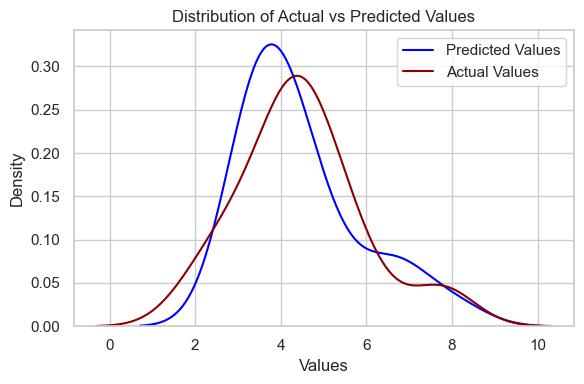

In [47]:
plot_distribution_actual_predicted(y_test, y_prediction)

In [48]:
# Only the highly correlated:
df_slice = df[['infection_risk', 'lenght_of_stay', 'routine_culturing_ratio']].copy()
# print(df.head())
y_test, y_prediction = apply_linear_regression(df_slice, target_variable)
print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

r2 and rmse: (0.5944386252755488, 0.8985099511972287)


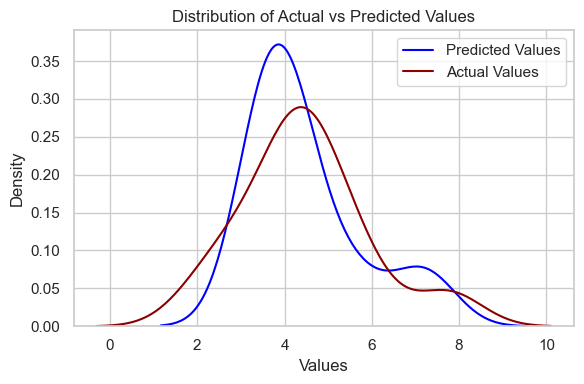

In [49]:
plot_distribution_actual_predicted(y_test, y_prediction)


* Analysis: Both linear regressions do not seem to fit the data well...

### Removing outliers and running the Linear Regression again
* Removing hospitals with lenght of stay 18 (ID 112) and 20 (ID 47)
* Removing hospitals with routine_culturing_ratio of 60 (ID 8), 50 (ID 54) and 46 (ID 110)

In [50]:
indexes_to_drop = [112,47]
df.loc[indexes_to_drop]

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,avg_census,num_nurses,avelbl_services,med_school_affil_1,med_school_affil_2,region_1,region_2,region_3,region_4
112,17.9,56.2,5.9,26.4,91.8,835,791,407,62.9,True,False,True,False,False,False
47,19.6,59.9,6.5,17.2,113.7,306,273,172,51.4,False,True,True,False,False,False


In [51]:
df_no_outliers = df.drop(index=indexes_to_drop)

In [52]:
target_variable = 'infection_risk'
# All the variables in the dataset:
y_test, y_prediction = apply_linear_regression(df_no_outliers, target_variable)
print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

r2 and rmse: (0.4489624583913444, 0.8391060098663727)


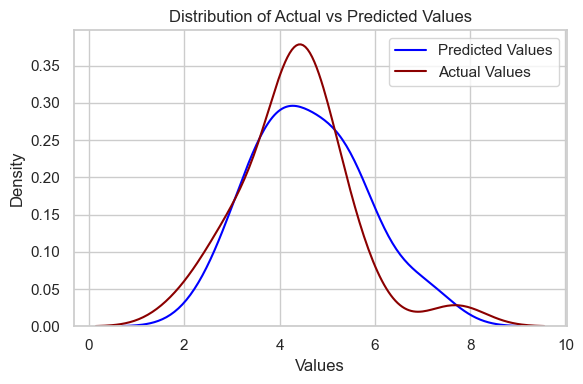

In [53]:
plot_distribution_actual_predicted(y_test, y_prediction)

In [54]:
# Only the highly correlated:
df_no_outliers_slice = df_no_outliers[['infection_risk', 'lenght_of_stay', 'routine_culturing_ratio']].copy()
# print(df.head())
y_test, y_prediction = apply_linear_regression(df_no_outliers_slice, target_variable)
print('r2 and rmse:', evaluate_linear_regression(y_test, y_prediction))

r2 and rmse: (0.2840264704860459, 0.9564774174906033)


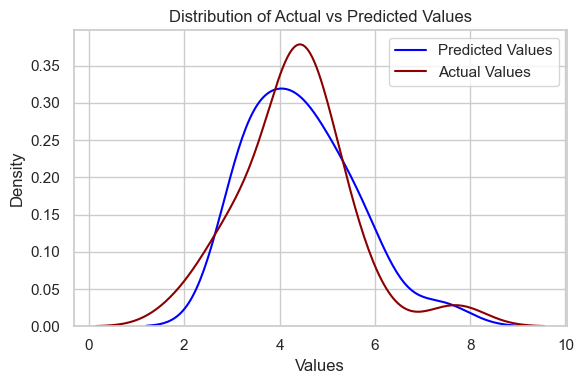

In [55]:
plot_distribution_actual_predicted(y_test, y_prediction)


## Doing the regression with MCMC
* First I'll do it with only one covariate (to test)

In [62]:
df_mcmc = df[['lenght_of_stay', 'infection_risk']]
df_mcmc.head()

,lenght_of_stay,infection_risk
1,7.1,4.1
2,8.8,1.6
3,8.3,2.7
4,8.9,5.6
5,11.2,5.7


In [63]:
x = np.array(df_mcmc)
x

array([[ 7.13,  4.1 ],
       [ 8.82,  1.6 ],
       [ 8.34,  2.7 ],
       [ 8.95,  5.6 ],
       [11.2 ,  5.7 ],
       [ 9.76,  5.1 ],
       [ 9.68,  4.6 ],
       [11.18,  5.4 ],
       [ 8.67,  4.3 ],
       [ 8.84,  6.3 ],
       [11.07,  4.9 ],
       [ 8.3 ,  4.3 ],
       [12.78,  7.7 ],
       [ 7.58,  3.7 ],
       [ 9.  ,  4.2 ],
       [11.08,  5.5 ],
       [ 8.28,  4.5 ],
       [11.62,  6.4 ],
       [ 9.06,  4.2 ],
       [ 9.35,  4.1 ],
       [ 7.53,  4.2 ],
       [10.24,  4.8 ],
       [ 9.78,  5.  ],
       [ 9.84,  4.8 ],
       [ 9.2 ,  4.  ],
       [ 8.28,  3.9 ],
       [ 9.31,  4.5 ],
       [ 8.19,  3.2 ],
       [11.65,  4.4 ],
       [ 9.89,  4.9 ],
       [11.03,  5.  ],
       [ 9.84,  5.2 ],
       [11.77,  5.3 ],
       [13.59,  6.1 ],
       [ 9.74,  6.3 ],
       [10.33,  5.  ],
       [ 9.97,  2.8 ],
       [ 7.84,  4.6 ],
       [10.47,  4.1 ],
       [ 8.16,  1.3 ],
       [ 8.48,  3.7 ],
       [10.72,  4.7 ],
       [11.2 ,  3.  ],
       [10.

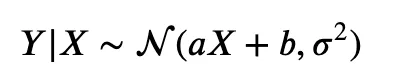

In [57]:
# Defining the proposal distributions for a, b and \sigma
# a and b will be Normal, \sigma will be Gamma

def proposal(prec_theta, search_width = 0.5):
    # this function generates the proposal for the new theta
    # we assume that the distribution of the random variables 
    # is normal for the first two and gamma for the third.
    # conditional on the previous value of the accepted parameters (prec_theta)
    out_theta = np.zeros(3)
    out_theta[:2] = sc.multivariate_normal(mean=prec_theta[:2],cov=np.eye(2)*search_width**2).rvs(1)
    #the last component is the noise
    out_theta[2] = sc.gamma(a=prec_theta[2]*search_width*500, scale=1/(500*search_width)).rvs()
    return out_theta


In [58]:
def lhd(x,theta):
    # x is the data matrix, first column for input and second column for output.
    # theta is a vector containing the parameters for the evaluation
    # remember theta[0] is a, theta[1] is b and theta[2] is sigma
    xs = x[:,0]
    ys = x[:,1]
    lhd_out = sc.norm.logpdf(ys, loc=theta[0]*xs+theta[1], scale=theta[2])
    # then we sum lhd_out (be careful here, we are summing instead of multiplying
    # because we are dealing with the log-likelihood, instead of the raw likelihood).
    lhd_out = np.sum(lhd_out)
    return lhd_out

In [59]:
def prior(theta):
    # evaluate the prior for the parameters on a multivariate gaussian. 
    prior_out = sc.multivariate_normal.logpdf(theta[:2],mean=np.array([0,0]), cov=np.eye(2)*100)
    # this needs to be summed to the prior for the sigma, since I assumed independence.
    prior_out += sc.gamma.logpdf(theta[2], a=1, scale=1)
    return prior_out

In [60]:
def proposal_ratio(theta_old, theta_new, search_width=10):
    # this is the proposal distribution ratio
    # first, we calculate of the pdf of the proposal distribution at the old value of theta with respect to the new 
    # value of theta. And then we do the exact opposite.
    prop_ratio_out = sc.multivariate_normal.logpdf(theta_old[:2],mean=theta_new[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out += sc.gamma.logpdf(theta_old[2], a=theta_new[2]*search_width*500, scale=1/(500*search_width))
    prop_ratio_out -= sc.multivariate_normal.logpdf(theta_new[:2],mean=theta_old[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out -= sc.gamma.logpdf(theta_new[2], a=theta_old[2]*search_width*500, scale=1/(500*search_width))
    return prop_ratio_out

In [77]:
np.random.seed(100)
width = 0.2
thetas = np.random.rand(3).reshape(1,-1)
accepted = 0
rejected = 0
data = x
N = 10000

for i in range(N):
    print(i)
    # 1) provide a proposal for theta
    theta_new = proposal(thetas[-1,:], search_width=width)
    
    # 2) calculate the likelihood of this proposal and the likelihood
    # for the old value of theta
    log_lik_theta_new = lhd(data,theta_new)
    log_lik_theta = lhd(data,thetas[-1,:])
    
    # 3) evaluate the prior log-pdf at the current and at the old value of theta
    theta_new_prior = prior(theta_new)
    theta_prior = prior(thetas[-1,:])
    
    # 4) finally, we need the proposal distribution ratio
    prop_ratio = proposal_ratio(thetas[-1], theta_new, search_width=width)
    
    # 5) assemble likelihood, priors and proposal distributions
    likelihood_prior_proposal_ratio = log_lik_theta_new - log_lik_theta + \
                             theta_new_prior - theta_prior + prop_ratio
    
    # 6) throw a - possibly infinitely weigthed - coin. The move for Metropolis-Hastings is
    # not deterministic. Here, we exponentiate the likelihood_prior_proposal ratio in order
    # to obtain the probability in linear scale
    if np.exp(likelihood_prior_proposal_ratio) > sc.uniform().rvs():
        thetas = np.vstack((thetas,theta_new))
        accepted += 1
    else:
        rejected += 1
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [81]:
thetas.shape[0]

462

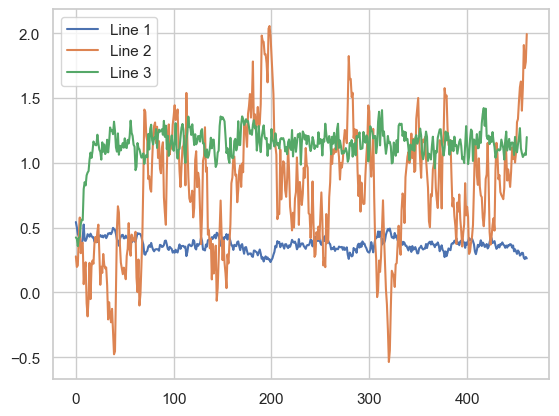

In [80]:
iteration = range(thetas.shape[0])
# Plotting each column as a line
plt.plot(iteration, thetas[:, 0], label='Line 1')  # First column as Line 1
plt.plot(iteration, thetas[:, 1], label='Line 2')  # Second column as Line 2
plt.plot(iteration, thetas[:, 2], label='Line 3')  # Third column as Line 3
plt.legend()

